Fake News Detector
==========================================

This project focuses on detecting fake news using a machine learning approach. The dataset contains 23,502 fake and 21,417 true news articles, with columns for title, text, subject, and date. 

- Text preprocessing involved lowercasing, removing special characters, numbers, and extra whitespace, eliminating stopwords, and lemmatizing words.
- The subject column was label-encoded, and TF-IDF vectorization was applied for feature extraction.
- A logistic regression model was trained, achieving high performance with training accuracy of 96.91%, validation accuracy of 96.80%, and test accuracy of 96.73%.

These results indicate robust model performance in distinguishing fake from true news articles.

# Importing Libraries 📚

In [2]:
pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
import re
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import scipy.sparse
import time
import os
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import pickle
from datetime import datetime

In [4]:
# Downloading NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Dataset Loading 📂

In [6]:
# Loading the dataset
fake_news = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
real_news = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')

In [7]:
# Labeling the dataset
fake_news['label'] = 0
real_news['label'] = 1

# Integrating the files into one 
df = pd.concat([fake_news, real_news], ignore_index=True)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total integrated articles: {len(df)}")
print("Dataset integration completed!")

Total integrated articles: 44898
Dataset integration completed!


# Data Exploration 🔎

In [8]:
# Data shape
df.shape

(44898, 5)

In [9]:
# Data Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [10]:
# Statistical Summary
df.describe(include = 'object')

,title,text,subject,date
count,44898,44898,44898,44898
unique,38729,38646,8,2397
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017"
freq,14,627,11272,182


In [11]:
# Cheching for missing values
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [12]:
# Checking for duplicates
df.duplicated().sum()

209

In [13]:
# Drop Duplicates
df.drop_duplicates(inplace = True)

# Data Visualization 📊

In [14]:
# Display the distribution
counts = df['label'].value_counts()
counts

label
0    23478
1    21211
Name: count, dtype: int64

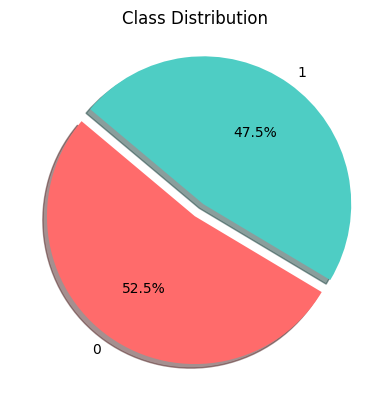

In [15]:
colors = ['#FF6B6B', '#4ECDC4']
plt.pie(counts, labels = counts.index, startangle = 140, shadow = True,
       explode =(0, 0.1), colors = colors, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

In [16]:
df_cleaned = df.copy()

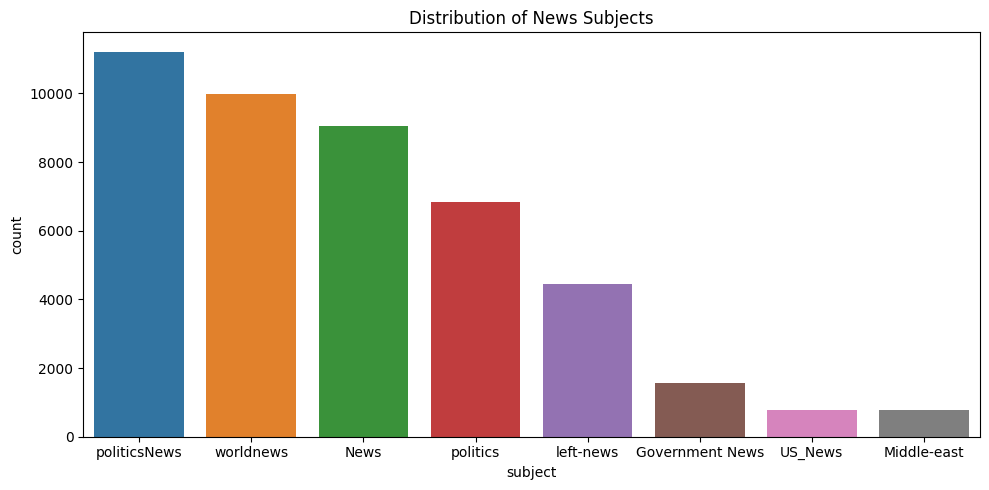

In [17]:
# 1. Distribution of Categories in subject
plt.figure(figsize=(10, 5))
sns.countplot(data=df_cleaned, x='subject', order=df_cleaned['subject'].value_counts().index)
plt.title("Distribution of News Subjects")
plt.tight_layout()
plt.show()


In [18]:
# 2. WordCloud for Fake and Real News 
# Separate the text
fake_text = " ".join(df_cleaned[df_cleaned['label'] == 1]['text'].astype(str))
real_text = " ".join(df_cleaned[df_cleaned['label'] == 0]['text'].astype(str))

def show_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400,
                          stopwords=stop_words,
                          background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()



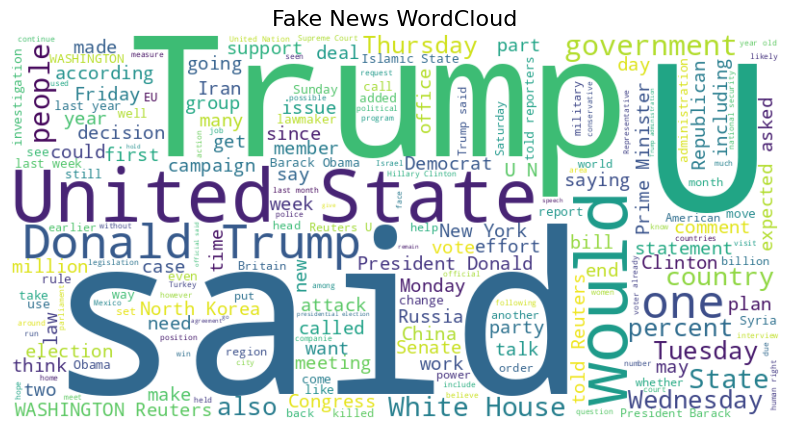

In [19]:
# Fake news word cloud
show_wordcloud(fake_text, "Fake News WordCloud")

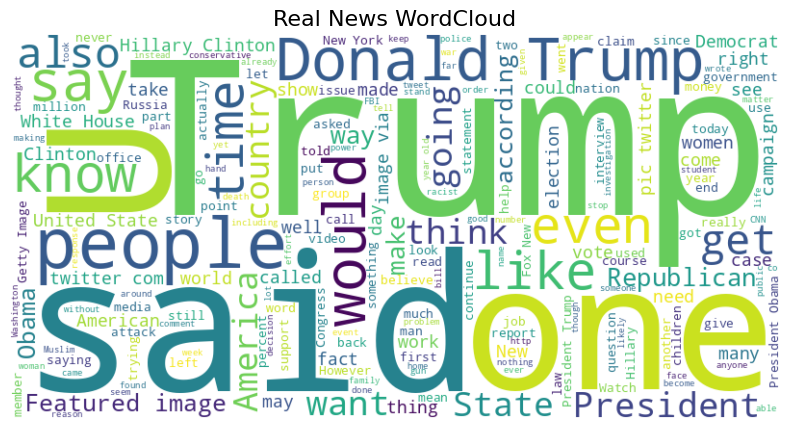

In [20]:
# Real news word cloud
show_wordcloud(real_text, "Real News WordCloud")

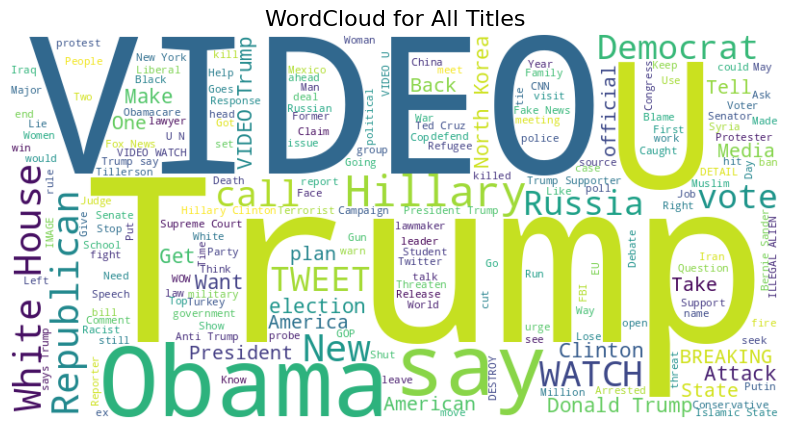

In [21]:
# 3. WordCloud for the title Column
title_text = " ".join(df_cleaned['title'].astype(str))
show_wordcloud(title_text, "WordCloud for All Titles")


Longest text length: 51794
Shortest text length: 1
Longest title length: 286
Shortest title length: 8


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


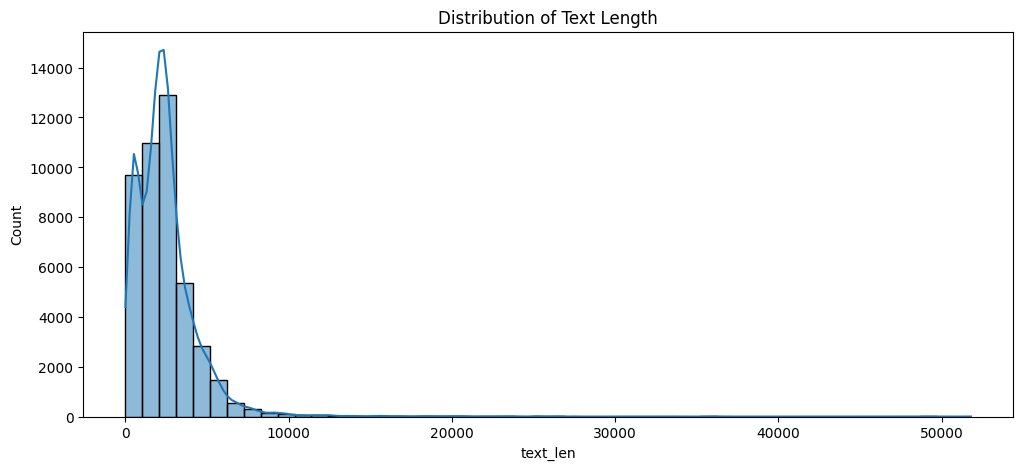

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


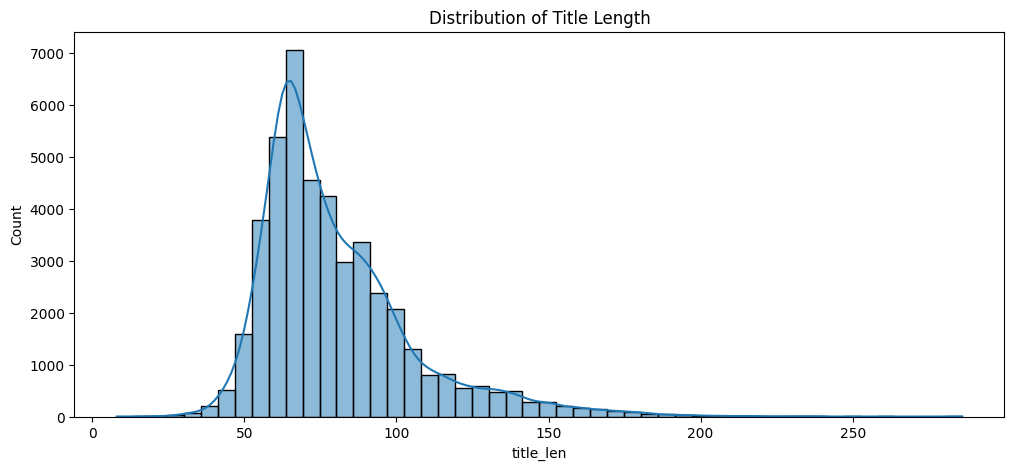

In [22]:
# 4. Longest and Shortest text and title
# Add length columns
df_cleaned['text_len'] = df_cleaned['text'].astype(str).apply(len)
df_cleaned['title_len'] = df_cleaned['title'].astype(str).apply(len)

# Longest and shortest
print("Longest text length:", df_cleaned['text_len'].max())
print("Shortest text length:", df_cleaned['text_len'].min())
print("Longest title length:", df_cleaned['title_len'].max())
print("Shortest title length:", df_cleaned['title_len'].min())

# Visualize distributions
plt.figure(figsize=(12, 5))
sns.histplot(df_cleaned['text_len'], bins=50, kde=True)
plt.title("Distribution of Text Length")
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df_cleaned['title_len'], bins=50, kde=True)
plt.title("Distribution of Title Length")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


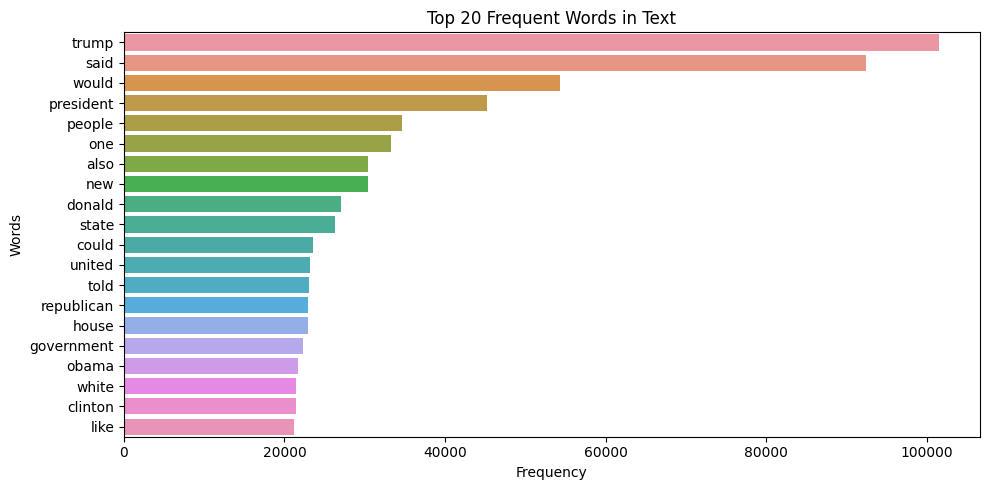

In [23]:
# 5. Frequency of Top Repeated Words 
# Combine all text
all_text = " ".join(df_cleaned['text'].astype(str))

# Tokenize and remove stopwords
words = [word.lower() for word in all_text.split() if word.lower() not in stop_words and word.isalpha()]
word_freq = Counter(words)

# Top 20 frequent words
common_words = word_freq.most_common(20)

# Plot
words, freqs = zip(*common_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(freqs), y=list(words))
plt.title("Top 20 Frequent Words in Text")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


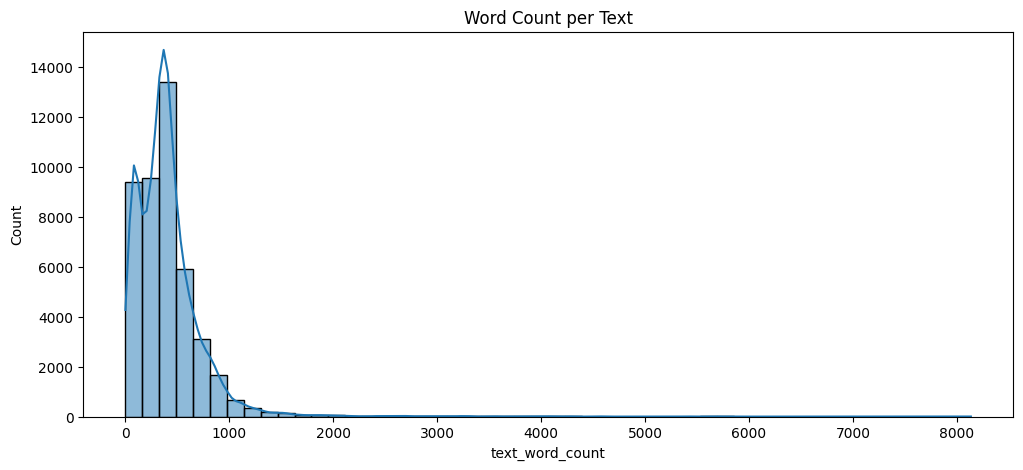

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


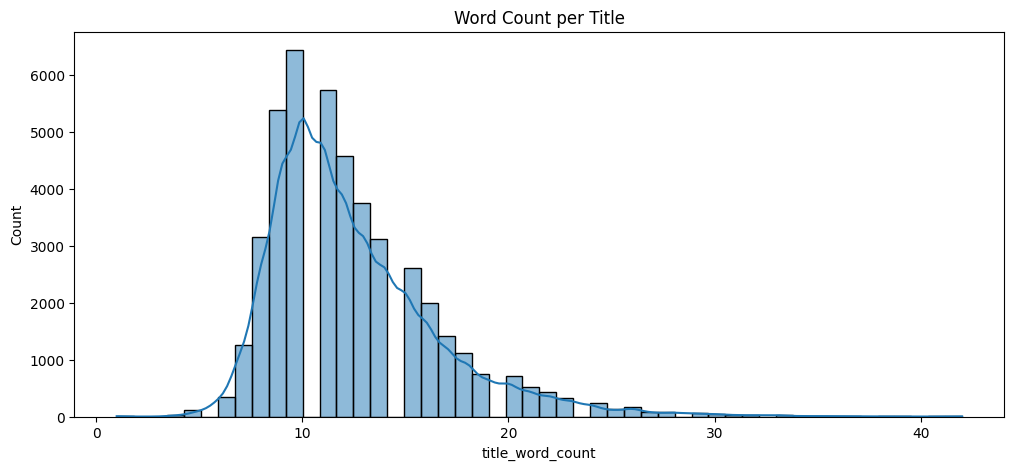

In [24]:
# Number of Words per Text / Title
df_cleaned['text_word_count'] = df_cleaned['text'].astype(str).apply(lambda x: len(x.split()))
df_cleaned['title_word_count'] = df_cleaned['title'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))
sns.histplot(df_cleaned['text_word_count'], bins=50, kde=True)
plt.title("Word Count per Text")
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df_cleaned['title_word_count'], bins=50, kde=True)
plt.title("Word Count per Title")
plt.show()


In [25]:
# Dropping the date column
df.drop('date', axis = 1, inplace = True)

In [26]:
# Exploring the categories in the subject column
df['subject'].unique()

array(['US_News', 'politicsNews', 'News', 'Government News', 'left-news',
       'worldnews', 'politics', 'Middle-east'], dtype=object)

In [27]:
df['title'].sample(5)

39027    Exclusive: 'We will kill you all' - Rohingya v...
37003     Sean Spicer Claims Hitler Never Gassed People...
1505     ALT-LEFT ATTACKS PHOENIX POLICE…Karma Hits Bac...
36203    Libyan force ready to cooperate on UK extradit...
23385    30 people killed in attack on cattle herders i...
Name: title, dtype: object

In [28]:
df['text'].sample(5)

14881    PARIS (Reuters) - Some 700 French adults, one-...
19497    Donald Trump thinks African-Americans are wors...
7783     Donald Trump has a major issue with Sen. Eliza...
7600     Trump spoke to his supporters at a rally in Cl...
32281    WASHINGTON (Reuters) - A joint U.S.-South Kore...
Name: text, dtype: object

# Data Preprocessing 🛠

## Text Cleaning

In [29]:
# Text Cleaning
def clean_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # 3. Remove numbers 
    text = re.sub(r'\d+', '', text)
    
    # 4. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 5. Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # 6. Lemmatize
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
        
    return text

In [30]:
# Apply cleaning inplace
df['title'] = df['title'].apply(clean_text)
df['text'] = df['text'].apply(clean_text)

## Data Splitting

In [31]:
# Separating the features and target
X = df[['title', 'text', 'subject']]
y = df['label']

In [32]:
# Data Splitting
# First-Split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, stratify = y, test_size = 0.15, random_state =42)
# Second-Split
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, stratify = y_temp, test_size = 0.175, random_state = 42)

## Label Encoding

In [33]:
# Initialize the Label Encoder
label_encoder = LabelEncoder()

# Fit on training data only
X_train['subject'] = label_encoder.fit_transform(X_train['subject'])

# Transform validation and test sets using the same encoder 
X_val['subject'] = label_encoder.transform(X_val['subject'])
X_test['subject'] = label_encoder.transform(X_test['subject'])


## Feature Extraction (TF-IDF Vectorizer)

In [34]:
# Initialize TF-IDF Vectorizers
tfidf_title = TfidfVectorizer(max_features=100, stop_words='english', lowercase=True, 
                                 min_df=5,               
                                 max_df=0.7,             
                                 ngram_range=(1, 1) )
tfidf_text = TfidfVectorizer(max_features=500, stop_words='english', lowercase=True, 
                                 min_df=5,               
                                 max_df=0.7,             
                                 ngram_range=(1, 1) )

# Fit and transform title column on training data
title_train_tfidf = tfidf_title.fit_transform(X_train['title'])
title_val_tfidf = tfidf_title.transform(X_val['title'])
title_test_tfidf = tfidf_title.transform(X_test['title'])

# Fit and transform text column on training data  
text_train_tfidf = tfidf_text.fit_transform(X_train['text'])
text_val_tfidf = tfidf_text.transform(X_val['text'])
text_test_tfidf = tfidf_text.transform(X_test['text'])

# Convert sparse matrices to dense arrays and replace original columns in-place
X_train['title'] = list(title_train_tfidf.toarray())
X_train['text'] = list(text_train_tfidf.toarray())

X_val['title'] = list(title_val_tfidf.toarray())
X_val['text'] = list(text_val_tfidf.toarray())

X_test['title'] = list(title_test_tfidf.toarray())
X_test['text'] = list(text_test_tfidf.toarray())

print(f"\nTF-IDF feature dimensions:")
print(f"Title features: {title_train_tfidf.shape[1]}")
print(f"Text features: {text_train_tfidf.shape[1]}")




TF-IDF feature dimensions:
Title features: 100
Text features: 500


In [35]:
# Prepare features by combining TF-IDF vectors with subject
def prepare_features(X_data):
    """
    Combine title, text TF-IDF features with subject into a single feature matrix
    """
    # Convert lists back to arrays and concatenate
    title_features = np.array(X_data['title'].tolist())
    text_features = np.array(X_data['text'].tolist()) 
    subject_features = X_data['subject'].values.reshape(-1, 1)
    
    # Combine all features
    combined_features = np.hstack([title_features, text_features, subject_features])
    return combined_features

# Prepare feature matrices
print("Preparing feature matrices...")
X_train_combined = prepare_features(X_train)
X_val_combined = prepare_features(X_val)
X_test_combined = prepare_features(X_test)

print(f"Combined feature dimensions:")
print(f"Training set: {X_train_combined.shape}")
print(f"Validation set: {X_val_combined.shape}")
print(f"Test set: {X_test_combined.shape}")


Preparing feature matrices...
Combined feature dimensions:
Training set: (31337, 601)
Validation set: (6648, 601)
Test set: (6704, 601)


# Modeling 🤖

## Logistic Regression

In [36]:
# Initialize and train Logistic Regression model
print("\nTraining Logistic Regression model...")

lr_model = LogisticRegression(
    C=0.005,                 
    max_iter=1000,
    random_state=42,
    solver='liblinear',
    penalty='l2'           
)


# Train the model
lr_model.fit(X_train_combined, y_train)
print("Model training completed!")




Training Logistic Regression model...
Model training completed!


# Evaluation 📈

In [37]:
# Make predictions
print("\nMaking predictions...")
y_train_pred = lr_model.predict(X_train_combined)
y_val_pred = lr_model.predict(X_val_combined)
y_test_pred = lr_model.predict(X_test_combined)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\n{'='*50}")
print("MODEL PERFORMANCE SUMMARY")
print(f"{'='*50}")
print(f"Training Accuracy:   {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Test Accuracy:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")



Making predictions...

MODEL PERFORMANCE SUMMARY
Training Accuracy:   0.9691 (96.91%)
Validation Accuracy: 0.9680 (96.80%)
Test Accuracy:       0.9673 (96.73%)



✅ Model shows good generalization!

CONFUSION MATRIX (Test Set)


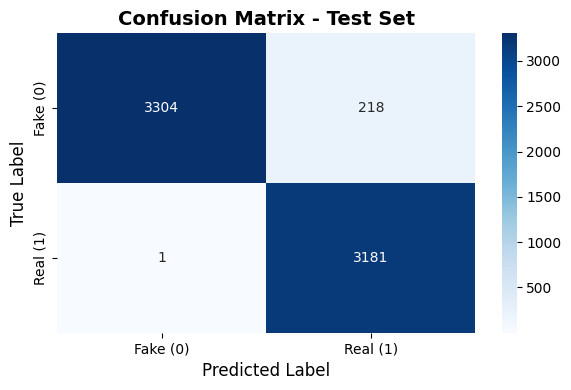

In [43]:
# Check for overfitting
if train_accuracy - val_accuracy > 0.05:
    print("\n⚠️  Warning: Potential overfitting detected!")
    print(f"   Training accuracy is {((train_accuracy - val_accuracy)*100):.2f}% higher than validation accuracy")
else:
    print("\n✅ Model shows good generalization!")

# Confusion Matrix for Test Set
print(f"\n{'='*50}")
print("CONFUSION MATRIX (Test Set)")
print(f"{'='*50}")

cm = confusion_matrix(y_test, y_test_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake (0)', 'Real (1)'],
            yticklabels=['Fake (0)', 'Real (1)'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()


In [39]:
# Classification Report
print(f"\n{'='*50}")
print("DETAILED CLASSIFICATION REPORT (Test Set)")
print(f"{'='*50}")

print(classification_report(y_test, y_test_pred, 
                          target_names=['Fake News (0)', 'Real News (1)'],
                          digits=4))


DETAILED CLASSIFICATION REPORT (Test Set)
               precision    recall  f1-score   support

Fake News (0)     0.9997    0.9381    0.9679      3522
Real News (1)     0.9359    0.9997    0.9667      3182

     accuracy                         0.9673      6704
    macro avg     0.9678    0.9689    0.9673      6704
 weighted avg     0.9694    0.9673    0.9674      6704



In [40]:
# Additional metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"\nKEY METRICS SUMMARY:")
print(f"Precision (Real News): {precision:.4f}")
print(f"Recall (Real News):    {recall:.4f}")
print(f"F1-Score (Real News):  {f1:.4f}")

# Model coefficients analysis (top features)
print(f"\n{'='*50}")
print("TOP PREDICTIVE FEATURES")
print(f"{'='*50}")

# Get feature names
n_title_features = title_train_tfidf.shape[1]
n_text_features = text_train_tfidf.shape[1]

# Get top positive and negative coefficients
coef = lr_model.coef_[0]
top_positive_idx = np.argsort(coef)[-10:][::-1]  # Top 10 positive
top_negative_idx = np.argsort(coef)[:10]         # Top 10 negative

print(f"\nTop 10 features indicating REAL news (positive coefficients):")
for i, idx in enumerate(top_positive_idx, 1):
    feature_type = "Title" if idx < n_title_features else ("Text" if idx < n_title_features + n_text_features else "Subject")
    print(f"{i:2d}. Feature {idx:5d} ({feature_type}): {coef[idx]:8.4f}")

print(f"\nTop 10 features indicating FAKE news (negative coefficients):")
for i, idx in enumerate(top_negative_idx, 1):
    feature_type = "Title" if idx < n_title_features else ("Text" if idx < n_title_features + n_text_features else "Subject")
    print(f"{i:2d}. Feature {idx:5d} ({feature_type}): {coef[idx]:8.4f}")

print(f"\n{'='*50}")
print("MODEL TRAINING COMPLETE!")
print(f"{'='*50}")


KEY METRICS SUMMARY:
Precision (Real News): 0.9359
Recall (Real News):    0.9997
F1-Score (Real News):  0.9667

TOP PREDICTIVE FEATURES

Top 10 features indicating REAL news (positive coefficients):
 1. Feature   600 (Subject):   0.9342
 2. Feature   471 (Text):   0.6174
 3. Feature    71 (Title):   0.4244
 4. Feature   578 (Text):   0.2455
 5. Feature    32 (Title):   0.2408
 6. Feature   466 (Text):   0.2386
 7. Feature    73 (Title):   0.1985
 8. Feature   376 (Text):   0.1848
 9. Feature   515 (Text):   0.1848
10. Feature   492 (Text):   0.1798

Top 10 features indicating FAKE news (negative coefficients):
 1. Feature    89 (Title):  -1.8159
 2. Feature    31 (Title):  -0.7562
 3. Feature    94 (Title):  -0.5221
 4. Feature   284 (Text):  -0.4352
 5. Feature     6 (Title):  -0.4140
 6. Feature   401 (Text):  -0.3378
 7. Feature   344 (Text):  -0.3340
 8. Feature    47 (Title):  -0.3240
 9. Feature    52 (Title):  -0.3232
10. Feature    51 (Title):  -0.3222

MODEL TRAINING COMPLETE

In [41]:
# Create a timestamp for the model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Kaggle working directory
kaggle_working_dir = '/kaggle/working/'

# Ensure we're in the working directory
os.chdir(kaggle_working_dir)
print(f"💾 Current directory: {os.getcwd()}")

# Method 1: Using joblib (recommended for sklearn models)
model_filename = f'fake_news_model_{timestamp}.joblib'
vectorizers_filename = f'fake_news_vectorizers_{timestamp}.joblib'
encoder_filename = f'fake_news_encoder_{timestamp}.joblib'

# Save your actual trained model
final_model = lr_model  
print("Saving your trained lr_model")

# Save to Kaggle working directory
joblib.dump(final_model, os.path.join(kaggle_working_dir, model_filename))
print(f"✅ Model saved as: {model_filename}")

# Save the TF-IDF vectorizers (using your original ones)
vectorizers = {
    'title_vectorizer': tfidf_title,   
    'text_vectorizer': tfidf_text      
}
joblib.dump(vectorizers, os.path.join(kaggle_working_dir, vectorizers_filename))
print(f"✅ Vectorizers saved as: {vectorizers_filename}")

# Save the label encoder
joblib.dump(label_encoder, os.path.join(kaggle_working_dir, encoder_filename))
print(f"✅ Label encoder saved as: {encoder_filename}")


💾 Current directory: /kaggle/working
Saving your trained lr_model
✅ Model saved as: fake_news_model_20250810_184348.joblib
✅ Vectorizers saved as: fake_news_vectorizers_20250810_184348.joblib
✅ Label encoder saved as: fake_news_encoder_20250810_184348.joblib
